# H1B Disclosure Dataset: Predicting the case Status
<br>

### Problem Statement:
The H-1B Dataset selected for this project contains data from employer’s Labor Condition
Application and the case certification determinations processed by the Office of Foreign Labor
Certification (OFLC) where the date of the determination was issued on or after October 1,
2016, and on or before June 30, 2017.<br>
<br>
The Labor Condition Application (LCA) is a document that a prospective H-1B employer files
with U.S. Department of Labor Employment and Training Administration (DOLETA) when it
seeks to employ nonimmigrant workers at a specific job occupation in an area of intended
employment for not more than three years.<br>
<br>
The goal for this project is to predict the case status of an application submitted by the employer
to hire non-immigrant workers under the H-1B visa program. The employer can hire
non-immigrant workers only after their LCA petition is approved. The approved LCA petition is
then submitted as part of the Petition for a Non-immigrant Worker application for work
authorizations for H-1B visa status.


In [2]:
# import libraries required to carry out data preprocessing and visualization
import pandas as pd
import numpy as np
import seaborn as sns
#sns.set(font_scale = 1)
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['font.size'] = 5
#plt.rc('xtick', labelsize=10) 
#plt.rc('ytick', labelsize=10)
import random
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

# import libraries to support modelling, hyperparameter tuning
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn import ensemble,model_selection

# import libraries to manage imbalanced data set
from imblearn.under_sampling import ClusterCentroids,RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler,SMOTE

#import sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

#import xgboost classifier
from xgboost import XGBClassifier

#import metrics required for model evaluation
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,roc_auc_score
from sklearn import metrics


In [5]:
# read the dataset
df = pd.read_csv('./data/H-1B_Disclosure_Data_FY17.csv',index_col=0)

In [6]:
df.shape

(624650, 52)

In [10]:
df.head(5)

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,EMPLOYMENT_START_DATE,EMPLOYMENT_END_DATE,EMPLOYER_NAME,EMPLOYER_BUSINESS_DBA,EMPLOYER_ADDRESS,...,H1B_DEPENDENT,WILLFUL_VIOLATOR,SUPPORT_H1B,LABOR_CON_AGREE,PUBLIC_DISCLOSURE_LOCATION,WORKSITE_CITY,WORKSITE_COUNTY,WORKSITE_STATE,WORKSITE_POSTAL_CODE,ORIGINAL_CERT_DATE
0,I-200-16055-173457,CERTIFIED-WITHDRAWN,2016-02-24,2016-10-01,H-1B,2016-08-10,2019-08-10,DISCOVER PRODUCTS INC.,NaN,2500 LAKE COOK ROAD,...,N,N,NaN,Y,NaN,RIVERWOODS,LAKE,IL,60015,2016-03-01
1,I-200-16064-557834,CERTIFIED-WITHDRAWN,2016-03-04,2016-10-01,H-1B,2016-08-16,2019-08-16,DFS SERVICES LLC,NaN,2500 LAKE COOK ROAD,...,N,N,NaN,Y,NaN,RIVERWOODS,LAKE,IL,60015,2016-03-08
2,I-200-16063-996093,CERTIFIED-WITHDRAWN,2016-03-10,2016-10-01,H-1B,2016-09-09,2019-09-09,EASTBANC TECHNOLOGIES LLC,NaN,1211 31ST ST. NW,...,Y,N,Y,NaN,NaN,WASHINGTON,NaN,DC,20007,2016-03-16
3,I-200-16272-196340,WITHDRAWN,2016-09-28,2016-10-01,H-1B,2017-01-26,2020-01-25,INFO SERVICES LLC,NaN,17177 NORTH LAUREL PARK DR,...,Y,N,Y,NaN,NaN,JERSEY CITY,HUDSON,NJ,07302,NaN
4,I-200-15053-636744,CERTIFIED-WITHDRAWN,2015-02-22,2016-10-02,H-1B,2015-03-01,2018-03-01,BB&T CORPORATION,NaN,223 WEST NASH STREET,...,N,N,NaN,Y,NaN,NEW YORK,NEW YORK,NY,10036,2015-02-26


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624650 entries, 0 to 624649
Data columns (total 52 columns):
CASE_NUMBER                    624650 non-null object
CASE_STATUS                    624650 non-null object
CASE_SUBMITTED                 624650 non-null object
DECISION_DATE                  624650 non-null object
VISA_CLASS                     624650 non-null object
EMPLOYMENT_START_DATE          624621 non-null object
EMPLOYMENT_END_DATE            624620 non-null object
EMPLOYER_NAME                  624594 non-null object
EMPLOYER_BUSINESS_DBA          43270 non-null object
EMPLOYER_ADDRESS               624643 non-null object
EMPLOYER_CITY                  624635 non-null object
EMPLOYER_STATE                 624632 non-null object
EMPLOYER_POSTAL_CODE           624632 non-null object
EMPLOYER_COUNTRY               528143 non-null object
EMPLOYER_PROVINCE              6116 non-null object
EMPLOYER_PHONE                 528142 non-null object
EMPLOYER_PHONE_EXT          

Data set is having 624K rows with 52 columns, the data set is big, lets see how many columns have null values in them.

In [9]:
df.isna().any().sum()

38

Out of 52 columns 38 have null values. I have used a method found on one of the kaggle kernel which takes in dataframe as input and gives dataframe containing null values in every columns and percentage of null values as output. We will remove features containing more than 50% null values.

In [3]:
#REMOVE COLUMNS BY NULL THRESHOLD
def missing_values_table(df):

        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
missing_df = missing_values_table(df);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print(missing_columns)
missing_df

Your selected dataframe has 52 columns.
There are 38 columns that have missing values.
['PUBLIC_DISCLOSURE_LOCATION', 'EMPLOYER_PROVINCE', 'EMPLOYER_PHONE_EXT', 'EMPLOYER_BUSINESS_DBA', 'ORIGINAL_CERT_DATE', 'SUPPORT_H1B', 'LABOR_CON_AGREE']


,Missing Values,% of Total Values
PUBLIC_DISCLOSURE_LOCATION,624650,100.0
EMPLOYER_PROVINCE,618534,99.0
EMPLOYER_PHONE_EXT,596778,95.5
EMPLOYER_BUSINESS_DBA,581380,93.1
ORIGINAL_CERT_DATE,574942,92.0
SUPPORT_H1B,384174,61.5
LABOR_CON_AGREE,379675,60.8
AGENT_ATTORNEY_STATE,288641,46.2
AGENT_ATTORNEY_CITY,273306,43.8
PW_WAGE_LEVEL,123720,19.8


In [15]:
df.EMPLOYER_COUNTRY.value_counts()

UNITED STATES OF AMERICA    528132
CANADA                           7
AUSTRALIA                        2
CHINA                            1
CAMBODIA                         1
Name: EMPLOYER_COUNTRY, dtype: int64

We will remove `PUBLIC_DISCLOSURE_LOCATION`, `EMPLOYER_PROVINCE`, `EMPLOYER_PHONE_EXT`, `EMPLOYER_BUSINESS_DBA`,`ORIGINAL_CERT_DATE`, `SUPPORT_H1B`, `LABOR_CON_AGREE` as they contain more than 50% values as null. <br>
We will also remove `WORKSITE_POSTAL_CODE`,`EMPLOYER_POSTAL_CODE`,`EMPLOYER_COUNTRY`as of now. 

In [19]:
cdf_ = df.copy().drop(['CASE_NUMBER','PUBLIC_DISCLOSURE_LOCATION', 'EMPLOYER_PROVINCE', 
                      'EMPLOYER_PHONE_EXT', 'EMPLOYER_BUSINESS_DBA',
                      'SUPPORT_H1B', 'LABOR_CON_AGREE','WORKSITE_POSTAL_CODE',
                       'EMPLOYER_POSTAL_CODE','EMPLOYER_COUNTRY'],axis=1)
print('shape:before dropping columns',df.shape,'\nshape:after dropping columns',cdf_.shape)

shape:before dropping columns (624650, 52) 
shape:after dropping columns (624650, 42)


In the dataset there are few date columns which can be used to derive new features.<br>
`CASE_SUBMITTED' and 'DECISION_DATE` can be used to make new column specifying number of `CASE_DAYS`.
`EMPLOYMENT_START_DATE` and `EMPLOYMENT_END_DATE` can be used to make new column `EMP_DAYS`.
We had `ORIGINAL_CERT_DATE` with 92% null values instead of dropping it I used it with `DECISION_DATE` to make new column `CERT_VAL_DAYS` specifying validity of certificate after decision date.<br>
Finally we will drop the all the dates columns.We could have kept the columns and transformed them to keep 'months' in it.

In [20]:
print('shape:before dropping columns',cdf_.shape)
cdf_['CASE_DAYS'] = pd.to_datetime(cdf_.loc[:,'DECISION_DATE']) - pd.to_datetime(cdf_.loc[:,'CASE_SUBMITTED'])
cdf_['CASE_DAYS'] = cdf_['CASE_DAYS'].apply(lambda x:str(x).split()[0]);
cdf_['CASE_DAYS'] = cdf_['CASE_DAYS'].astype('int64');

cdf_['EMP_DAYS'] = pd.to_datetime(cdf_.loc[:,'EMPLOYMENT_END_DATE']) - pd.to_datetime(cdf_.loc[:,'EMPLOYMENT_START_DATE'])
cdf_['EMP_DAYS'] = cdf_['EMP_DAYS'].apply(lambda x:str(x).split()[0]);
cdf_['EMP_DAYS'] = cdf_['EMP_DAYS'].apply(lambda x:0 if x=='NaT' else x);
cdf_['EMP_DAYS'] = cdf_['EMP_DAYS'].astype('int64');

cdf_['CERT_VAL_DAYS'] = pd.to_datetime(cdf_.loc[:,'DECISION_DATE']) - pd.to_datetime(cdf_.loc[:,'ORIGINAL_CERT_DATE'])
cdf_['CERT_VAL_DAYS'] = cdf_['CERT_VAL_DAYS'].apply(lambda x:str(x).split()[0]);
cdf_['CERT_VAL_DAYS'] = cdf_['CERT_VAL_DAYS'].apply(lambda x:0 if x=='NaT' else x);
cdf_['CERT_VAL_DAYS'] = cdf_['CERT_VAL_DAYS'].astype('int64');

cdf_ = cdf_.drop(['DECISION_DATE','CASE_SUBMITTED','EMPLOYMENT_START_DATE',
                'EMPLOYMENT_END_DATE','ORIGINAL_CERT_DATE'],axis=1)
print('shape:after dropping columns',cdf_.shape)


shape:before dropping columns (624650, 42)
shape:after dropping columns (624650, 40)


In [21]:
cdf_.PW_SOURCE_YEAR.value_counts()

2016.0    437864
2017.0    157657
2015.0     17413
2014.0      8236
2013.0      2992
2011.0       241
2012.0       108
2009.0        30
2010.0        19
2008.0        18
2007.0        13
2001.0         5
0.0            2
2000.0         1
1999.0         1
1998.0         1
1993.0         1
1985.0         1
1.0            1
15.0           1
Name: PW_SOURCE_YEAR, dtype: int64

In [ ]:
#PW_SOURCE_YEAR is float type,we will convert it to category, there are few outliers in this column
cdf_['PW_SOURCE_YEAR'] = cdf_['PW_SOURCE_YEAR'].astype('category')

Its always a good practise to make new copies of dataframe after modifications, if we want to go back one step its more easier if we have copy otherwise we will have to execute all the cells right from the start.

In [24]:
cdf = cdf_.copy()

I have read the metadata that came along with dataset, So I already know that there are multiple visa classes but we just want to predict for h-1b hence we filter our dataframe to have just h-1b cases. Once we filter out h-1b case we can drop `VISA_CLASS` now it contains same value i.e H-1B.

In [25]:
cdf.VISA_CLASS.value_counts()

H-1B               610304
E-3 Australian      12157
H-1B1 Singapore      1254
H-1B1 Chile           935
Name: VISA_CLASS, dtype: int64

In [6]:
cdf = cdf[cdf['VISA_CLASS']=='H-1B']
print(cdf.VISA_CLASS.value_counts())
cdf.drop('VISA_CLASS',axis=1,inplace=True)
print('shape is',cdf.shape)

H-1B    610304
Name: VISA_CLASS, dtype: int64
shape is (610304, 39)


In [27]:
cdf.JOB_TITLE.isna().any().sum()

1

In [28]:
#there is one null value in JOB_TITLE, we will drop that row.
cdf.dropna(subset=['JOB_TITLE'],inplace=True)

As per metadata of this dataset there are four classes in `CASE_STATUS`,out of which we required to have two classes namely `CERTIFIED` and `DENIED`. We can rename `CERTIFIED-WITHDRAWN` labels as `CERTIFIED`. 

In [29]:
cdf.CASE_STATUS.value_counts()

CERTIFIED              545692
CERTIFIED-WITHDRAWN     49704
WITHDRAWN               20769
DENIED                   8480
Name: CASE_STATUS, dtype: int64

In [30]:
#filtering out withdrawn cases
cdf = cdf.loc[cdf.CASE_STATUS.isin(['CERTIFIED-WITHDRAWN','CERTIFIED','DENIED'])]
print('new shape is',cdf.shape)

#renaming certified-withdrawn as certified
cdf.CASE_STATUS.loc[cdf.CASE_STATUS=='CERTIFIED-WITHDRAWN'] = 'CERTIFIED'
print(cdf.CASE_STATUS.value_counts())
print('new shape is',cdf.shape)

new shape is (603876, 40)
CERTIFIED    595396
DENIED         8480
Name: CASE_STATUS, dtype: int64
new shape is (603876, 40)


Notice that target is having imbalance which we need to handle it using resampling techniques, otherwise model will be biased towards detecting `CERTIFIED` cases as they are in majority.<br>
Firstly we will build model without resampling and then with resampling.

Now lets use real life problem solving approach, first we will split the data in two parts training set of 75% and test set of 25% with stratification. 

In [33]:
X = cdf.drop('CASE_STATUS',axis=1);
y = cdf.CASE_STATUS
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,stratify=y,test_size=0.25);

Lets make copies of train and test data and work with the copied frames. First we will create some new columns based on missing values of available columns. These new columns will have two labels 'True' or 'False' based on actual values in column if null or not.

In [38]:
# make copy to isolate changes we have done before
idf = X_train.copy()
idf1 = X_test.copy()

# make a list of column names which contain null values
cols_with_missing = [col for col in idf.columns 
                                 if idf[col].isnull().any()]

print('number of columns with missing values',len(cols_with_missing))
print('train shape before creating _missing columns',idf.shape)
print('test shape before creating _missing columns',idf1.shape)

for col in cols_with_missing:
    idf[col + '_was_missing'] = idf[col].isnull()
    idf1[col + '_was_missing'] = idf1[col].isnull()

print('train shape after creating _missing columns',idf.shape)
print('test shape after creating _missing columns',idf1.shape)
print('columns with missing values are',cols_with_missing)

number of columns with missing values 24
train shape before creating _missing columns (452907, 39)
test shape before creating _missing columns (150969, 39)
train shape after creating _missing columns (452907, 63)
test shape after creating _missing columns (150969, 63)
columns with missing values are ['EMPLOYER_NAME', 'EMPLOYER_ADDRESS', 'EMPLOYER_CITY', 'EMPLOYER_STATE', 'EMPLOYER_PHONE', 'AGENT_REPRESENTING_EMPLOYER', 'AGENT_ATTORNEY_CITY', 'AGENT_ATTORNEY_STATE', 'SOC_NAME', 'NAICS_CODE', 'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'PW_UNIT_OF_PAY', 'PW_WAGE_LEVEL', 'PW_SOURCE', 'PW_SOURCE_YEAR', 'PW_SOURCE_OTHER', 'WAGE_RATE_OF_PAY_TO', 'WAGE_UNIT_OF_PAY', 'H1B_DEPENDENT', 'WILLFUL_VIOLATOR', 'WORKSITE_CITY', 'WORKSITE_COUNTY', 'WORKSITE_STATE']


We have 24 columns with missing values, at this point I decided to create MISC label for null values in few features and for some feature where null values are low I decided to drop them.

In [39]:
idf.AGENT_REPRESENTING_EMPLOYER.fillna('MISC',inplace=True)
idf1.AGENT_REPRESENTING_EMPLOYER.fillna('MISC',inplace=True)
idf.AGENT_ATTORNEY_NAME.fillna('MISC',inplace=True)
idf1.AGENT_ATTORNEY_NAME.fillna('MISC',inplace=True)
idf.AGENT_ATTORNEY_CITY.fillna('MISC',inplace=True)
idf1.AGENT_ATTORNEY_CITY.fillna('MISC',inplace=True)
idf.AGENT_ATTORNEY_STATE.fillna('MISC',inplace=True)
idf1.AGENT_ATTORNEY_STATE.fillna('MISC',inplace=True)
idf.EMPLOYER_CITY.fillna('MISC',inplace=True)
idf1.EMPLOYER_CITY.fillna('MISC',inplace=True)
idf.EMPLOYER_STATE.fillna('MISC',inplace=True)
idf1.EMPLOYER_STATE.fillna('MISC',inplace=True)
idf.SOC_NAME.fillna('MISC',inplace=True)
idf1.SOC_NAME.fillna('MISC',inplace=True)
idf.WORKSITE_CITY.fillna('MISC',inplace=True)
idf1.WORKSITE_CITY.fillna('MISC',inplace=True)
idf.WORKSITE_STATE.fillna('MISC',inplace=True)
idf1.WORKSITE_STATE.fillna('MISC',inplace=True)
idf.WORKSITE_COUNTY.fillna('MISC',inplace=True)
idf1.WORKSITE_COUNTY.fillna('MISC',inplace=True)
idf.PW_SOURCE_OTHER.fillna('MISC',inplace=True)
idf1.PW_SOURCE_OTHER.fillna('MISC',inplace=True)

idf.dropna(subset=['FULL_TIME_POSITION','PW_UNIT_OF_PAY','PW_SOURCE',
                   'PW_SOURCE_YEAR','WAGE_UNIT_OF_PAY','H1B_DEPENDENT',
                   'WILLFUL_VIOLATOR','WAGE_RATE_OF_PAY_TO'],inplace=True)
idf1.dropna(subset=['FULL_TIME_POSITION','PW_UNIT_OF_PAY','PW_SOURCE',
                    'PW_SOURCE_YEAR','WAGE_UNIT_OF_PAY','H1B_DEPENDENT',
                    'WILLFUL_VIOLATOR','WAGE_RATE_OF_PAY_TO'],inplace=True)

We will drop some features, we still have information about whether data for these features was available or not in their respective `_was_missing` columns. We can later use `EMPLOYER_NAME` and check for any improvements.

In [40]:
idf.drop('EMPLOYER_PHONE',axis=1,inplace=True)
idf1.drop('EMPLOYER_PHONE',axis=1,inplace=True)
idf.drop('NAICS_CODE',axis=1,inplace=True)
idf1.drop('NAICS_CODE',axis=1,inplace=True)
idf.drop('EMPLOYER_NAME',axis=1,inplace=True)
idf1.drop('EMPLOYER_NAME',axis=1,inplace=True)
idf.drop('EMPLOYER_ADDRESS',axis=1,inplace=True)
idf1.drop('EMPLOYER_ADDRESS',axis=1,inplace=True)

print('train shape',idf.shape)
print('test shape',idf1.shape)

train shape (442979, 59)
test shape (147538, 59)


In [41]:
# lets see how many columns still have nulls, we will use this list duting imputing 
#to impute only those columns which have missing values.
cols_with_missing = [col for col in idf.columns 
                                 if idf[col].isnull().any()]
print('number of columns with missing values',len(cols_with_missing))


number of columns with missing values 1


We will separate out numeric and categorical features and do imputing with 'median' for numeric or with 'mode' for categorical features.

In [42]:
idf_num = idf.select_dtypes(exclude='object');
idf_cat = idf.select_dtypes(include='object');

idf1_num = idf1.select_dtypes(exclude='object');
idf1_cat = idf1.select_dtypes(include='object');

In [44]:
#We will use SimpleImputer function of sklearn, earlier imputer was used which is deprecated now.
my_imputer_num = SimpleImputer()

for i in range(len(idf_num.columns)):
    if idf_num.columns[i] in cols_with_missing:
        print('imputing on numeric column', idf_num.columns[i])
        print('X train NaNs before',idf_num[idf_num.columns[i]].isna().sum())
        temp_train = pd.DataFrame(idf_num[idf_num.columns[i]],index=idf_num.index)
        temp_test = pd.DataFrame(idf1_num[idf_num.columns[i]],index=idf1_num.index)
        idf_num[idf_num.columns[i]] = my_imputer_num.fit_transform(temp_train)
        idf1_num[idf_num.columns[i]] = my_imputer_num.transform(temp_test)
        print('X train NaNs after',idf_num[idf_num.columns[i]].isna().sum())

In [45]:
my_imputer_cat = SimpleImputer(strategy='most_frequent')
#X_train_num.columns = idf_num.columns
for i in range(len(idf_cat.columns)):
    if idf_cat.columns[i] in cols_with_missing:
        print('imputing on cat column', idf_cat.columns[i])
        print('X train NaNs before',idf_cat[idf_cat.columns[i]].isna().sum())
        temp_train = pd.DataFrame(idf_cat[idf_cat.columns[i]],index=idf_cat.index)
        temp_test = pd.DataFrame(idf1_cat[idf_cat.columns[i]],index=idf1_cat.index)
        idf_cat[idf_cat.columns[i]] = my_imputer_cat.fit_transform(temp_train)
        idf1_cat[idf_cat.columns[i]] = my_imputer_cat.transform(temp_test)
        print('X train NaNs after',idf_cat[idf_cat.columns[i]].isna().sum())

imputing on cat column PW_WAGE_LEVEL
X train NaNs before 86185
X train NaNs after 0


Lets save our work done till now in new data frames and then use new data frames to process further.

In [46]:
#X_train_cat.colums = idf_cat.columns
X_train_num = idf_num.copy()
X_test_num = idf1_num.copy()
X_train_cat = idf_cat.copy()
X_test_cat = idf1_cat.copy()

In [47]:
print('x train num shape',X_train_num.shape)
print('x test num shape',X_test_num.shape)
print('x train cat shape',X_train_cat.shape)
print('x test cat shape',X_test_cat.shape)

x train num shape (442979, 38)
x test num shape (147538, 38)
x train cat shape (442979, 21)
x test cat shape (147538, 21)


While doing label encoding I had observed one issue that there are few labels which are just 1 in number so while doing tranform we get 'unseen label' error. To tackle that I decided to fit on original data frame, remember we had replaced nulls in some column with MISC, we will have to introduce this label in original dataframe. when I say original I mean to say copy of original dataframe as I dont want to alter anything in original data frame.

In [48]:
cdf1 = cdf.copy()
cdf1.AGENT_REPRESENTING_EMPLOYER.fillna('MISC',inplace=True)
cdf1.AGENT_ATTORNEY_NAME.fillna('MISC',inplace=True)
cdf1.AGENT_ATTORNEY_CITY.fillna('MISC',inplace=True)
cdf1.AGENT_ATTORNEY_STATE.fillna('MISC',inplace=True)

cdf1.EMPLOYER_CITY.fillna('MISC',inplace=True)
cdf1.EMPLOYER_STATE.fillna('MISC',inplace=True)

cdf1.WORKSITE_STATE.fillna('MISC',inplace=True)
cdf1.WORKSITE_COUNTY.fillna('MISC',inplace=True)
cdf1.WORKSITE_CITY.fillna('MISC',inplace=True)

cdf1.SOC_NAME.fillna('MISC',inplace=True)

cdf1.FULL_TIME_POSITION.fillna('MISC',inplace=True)
cdf1.PW_SOURCE_OTHER.fillna('MISC',inplace=True)

Apply label encoding on categorical features

In [49]:
le = LabelEncoder()

cat_var = X_train_cat.columns.values.tolist()
for i in range(0,len(cat_var)):
    print(cat_var[i])
    
    le.fit(cdf1[cat_var[i]].astype(str))
    X_train_cat[cat_var[i]] = le.transform(X_train_cat[cat_var[i]])
    X_test_cat[cat_var[i]] = le.transform(X_test_cat[cat_var[i]])



VISA_CLASS
EMPLOYER_CITY
EMPLOYER_STATE
AGENT_REPRESENTING_EMPLOYER
AGENT_ATTORNEY_NAME
AGENT_ATTORNEY_CITY
AGENT_ATTORNEY_STATE
JOB_TITLE
SOC_CODE
SOC_NAME
FULL_TIME_POSITION
PW_UNIT_OF_PAY
PW_WAGE_LEVEL
PW_SOURCE
PW_SOURCE_OTHER
WAGE_UNIT_OF_PAY
H1B_DEPENDENT
WILLFUL_VIOLATOR
WORKSITE_CITY
WORKSITE_COUNTY
WORKSITE_STATE


Now lets combine categorical and numeric X training and X testing sets, so we will have just X train and X test. For some reason we might want to use multiple computers to do modelling since we dont have enough computing resources locally.To do that we can create training and testing sets save them to csv and send it to your team mates so they can start with modelling right away!
<br>

NOTE: 
we have done many changes in X train and X test, we have removed rows but we havent removed same rows in y train and y test. Hence while merging x and y make sure we add code for indexing as in below code.

In [51]:
print('X_train_cat shape',X_train_cat.shape)
print('X_train_num shape',X_train_num.shape)
print('X_test_cat shape',X_test_cat.shape)
print('X_test_num shape',X_test_num.shape)

X_train_1 = pd.concat([X_train_cat,X_train_num],axis=1);
X_test_1 = pd.concat([X_test_cat,X_test_num],axis=1);

print('X_train shape',X_train_1.shape)
print('X_test shape',X_test_1.shape)

#indexing align y train and test with x train and test
y_train = y_train[X_train_1.index]
y_test = y_test[X_test_1.index]

training_data = pd.concat([X_train_1,y_train],axis=1)
testing_data = pd.concat([X_test_1,y_test],axis=1)

print('training data shape',training_data.shape)
print('testing data shape',testing_data.shape)

#training_data.to_csv('train_data.csv',index=False)
#testing_data.to_csv('test_data.csv',index=False)

X_train_cat shape (442979, 21)
X_train_num shape (442979, 38)
X_test_cat shape (147538, 21)
X_test_num shape (147538, 38)
X_train shape (442979, 59)
X_test shape (147538, 59)
training data shape (442979, 60)
testing data shape (147538, 60)


In [52]:
#label encoding for target before applying models
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

Lets first do random forest model without resampling

In [53]:
rf = RandomForestClassifier(random_state=42,max_depth=12)
rf.fit(X_train_1,y_train)
y_pred = rf.predict(X_test_1)
print('f1-score',f1_score(y_test,y_pred))
print('AUC score',roc_auc_score(y_test,y_pred))

f1-score 0.65643952907599
AUC score 0.7458166402003189


I had checked result with cluser centroid i.e undersampling and when compared with SMOTE i.e oversampling, latter was better. So lets stick with SMOTE after resampling we will again check with random forest model.

In [54]:
smote = SMOTE(random_state=42)
X_sample1, y_sample1 = smote.fit_sample(X_train_1,y_train)

In [20]:
'''cc = RandomUnderSampler(random_state=42)
X_sample2,y_sample2 = cc.fit_sample(X_train_1,y_train)'''

'cc = RandomUnderSampler(random_state=42)\nX_sample2,y_sample2 = cc.fit_sample(X_train_1,y_train)'

In [55]:
rf = RandomForestClassifier(random_state=42,max_depth=12)
rf.fit(X_sample1,y_sample1)
y_pred = rf.predict(X_test_1)
print('f1-score',f1_score(y_test,y_pred))
print('AUC score',roc_auc_score(y_test,y_pred))

f1-score 0.5878853434288805
AUC score 0.7879463309704973


In [56]:
rf = RandomForestClassifier(random_state=42,max_depth=None)
rf.fit(X_sample1,y_sample1)
y_pred = rf.predict(X_test_1)
print('f1-score',f1_score(y_test,y_pred))
print('AUC score',roc_auc_score(y_test,y_pred))

f1-score 0.6619718309859155
AUC score 0.7633370654300194


We will check cross validation score to check whether our model is overfitting or not, if the score is consistent across folds that means our model is not overfitting.

In [57]:
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
scores = cross_val_score(rf, X_sample1, y_sample1, cv=kf, scoring='f1_macro')
scores

array([0.9969299 , 0.99664404, 0.99642108, 0.99657544, 0.99680981])

In [60]:
from sklearn import ensemble
vote_est = [('rfc', RandomForestClassifier(n_estimators=100,max_depth=8)),
            ('lr', LogisticRegression(C=0.1)),
            ('xgb', XGBClassifier(max_depth=10,n_estimators=300)),
            ('ada', AdaBoostClassifier(learning_rate=0.3,n_estimators=300))]
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_hard.fit(X_sample1,y_sample1)


In [59]:
X = np.array(X_test_1)
y_pred = vote_hard.predict(X)
print(('roc score'),roc_auc_score(y_test,y_pred))
print(('f1 score'),f1_score(y_test,y_pred))
print(('accuracy score'),accuracy_score(y_test,y_pred))

roc score 0.7888427070966285
f1 score 0.646813579511614
accuracy score 0.9919613929970584


In [61]:
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard.fit(X_sample1,y_sample1)
y_pred = vote_hard.predict(X)
print(('roc score'),roc_auc_score(y_test,y_pred))
print(('f1 score'),f1_score(y_test,y_pred))
print(('accuracy score'),accuracy_score(y_test,y_pred))

roc score 0.7769886766877634
f1 score 0.6380631320870365
accuracy score 0.9919952825712698


In [63]:

#Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [
            [{
            #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
            'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
            'random_state': grid_seed
            }],
       

            [{
            #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
            #'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'n_estimators': [300], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }],

    
            [{
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }],
    
            [{
            #SVC 
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'gamma': grid_ratio, #edfault: auto
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'probability': [True],
            'random_state': grid_seed
             }],

    
            [{
            #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
            'learning_rate': grid_learn, #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }]   
        ]

In [64]:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )


In [65]:
start = time.perf_counter()        
best_search = model_selection.GridSearchCV(estimator = vote_est[2][1], 
                                           param_grid = grid_param[2][0], cv = cv_split,
                                           scoring = 'roc_auc')
best_search.fit(X_sample1, y_sample1)
run = time.perf_counter() - start

best_param = best_search.best_params_
print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(vote_est[2][1].__class__.__name__, best_param, run))


![result](./files/gridsearch-rf.jpg "result")

In [67]:
#best parameters for grid search with RF for 'roc_auc' scoring function as well as for 'f1' scoring function
rf = RandomForestClassifier(random_state=42,max_depth=None,n_estimators=300,oob_score=True)
rf.fit(X_sample1,y_sample1)
y_pred = rf.predict(X_test_1)
print('f1-score',f1_score(y_test,y_pred))
print('AUC score',roc_auc_score(y_test,y_pred))

f1-score 0.6914893617021276
AUC score 0.7775932914678108


### FEATURE IMPORTANCE

In [68]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(X_train_1.columns),
                                'importance': rf.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)


<Figure size 864x1440 with 0 Axes>

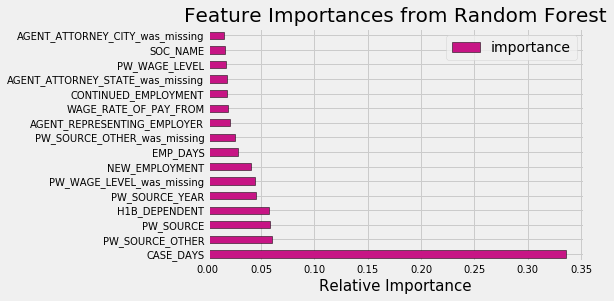

In [70]:
plt.figure(figsize=(12, 20))
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:15, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'mediumvioletred',fontsize=10);
plt.xlabel('Relative Importance', size = 15); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 20);

### ROC AUC CURVE

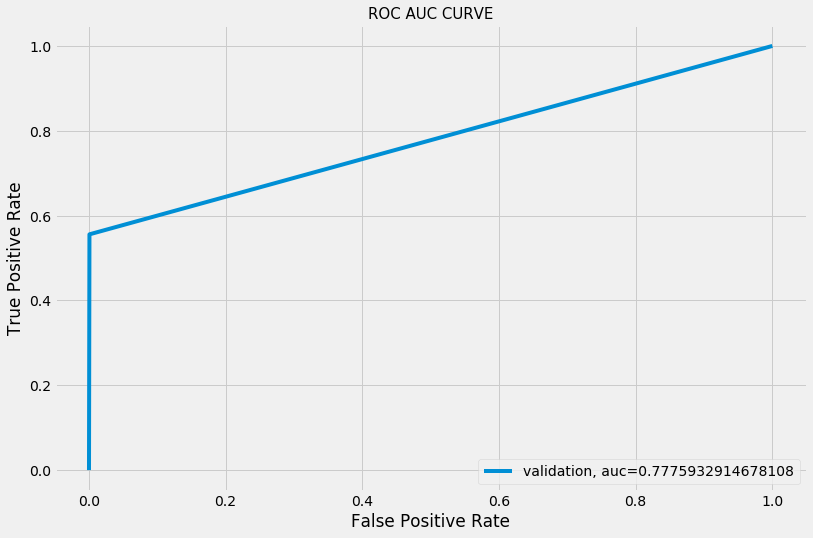

In [71]:
fpr, tpr, _ = metrics.roc_curve(y_test,y_pred)
auc = metrics.roc_auc_score(y_test,y_pred)
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr,label="validation, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.title('ROC AUC CURVE',fontsize=15)
plt.show()

This was just a simple approach to predict H-1B case status, remember we had dropped few features in between like `EMPLOYER_CITY`,`EMPLOYER_NAME`,`POSTAL_CODE` etc. You can take that as an improvement over this kernel. If you get better results do let me know, until then see you and happy learning.